In [32]:
import numpy as np
import matplotlib.pyplot as plt

from roboticstoolbox import models
import roboticstoolbox as rtb
from scipy.integrate import odeint
from webencodings import labels

# Загрузка модели UR5
robot = models.DH.UR5()

# Вывод DH-параметров
print("Параметры Денавита-Хартенберга:")
for i in range(len(robot.links)):
    print(f"Звено {i}: {robot.links[i]}")
# Массы звеньев (кг)
masses = [3.7, 6.8, 4.8, 0.8, 0.8, 0.8]

# Центр масс каждого звена (в локальной системе координат)
centers_of_mass = [
    [0, 0, -0.08],  # Звено 1
    [0, -0.12, 0],  # Звено 2
    [0, 0, -0.12],  # Звено 3
    [0, 0, 0],  # Звено 4
    [0, 0, 0],  # Звено 5
    [0, 0, 0]  # Звено 6
]

# Тензоры инерции (Lxx, Lyy, Lzz, Lxy, Lyz, Lxz)
inertias = [
    [0.0, 0.09, 0.09, 0, 0, 0],  # Звено 1
    [0.23, 0.2, 0.03, 0, 0, 0],  # Звено 2
    [0.02, 0.02, 0.03, 0, 0, 0],  # Звено 3
    [0.001, 0.001, 0.001, 0, 0, 0],  # Звено 4
    [0.001, 0.001, 0.001, 0, 0, 0],  # Звено 5
    [0.001, 0.001, 0.001, 0, 0, 0]  # Звено 6
]

# Момент инерции двигателей (примерно)
Jm = [0.0001, 0.0004, 0.0001, 0.00001, 0.00001, 0.00001]

# Коэффициенты вязкого трения
B = [0.1, 0.1, 0.05, 0.01, 0.01, 0.01]

# Коэффициенты кулоновского трения (±)
Tc = [0.3, 0.5, 0.3, 0.1, 0.1, 0.1]

# Передаточные числа редукторов
G = [100, 100, 100, 50, 50, 50]

# Ограничения по обобщенным координатам (радианы)
qlim = [
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi]
]

# Присвоение динамических параметров каждому звену
for i in range(6):
    robot.links[i].m = masses[i]
    robot.links[i].r = centers_of_mass[i]
    robot.links[i].I = inertias[i]
    robot.links[i].Jm = Jm[i]
    robot.links[i].B = B[i]
    robot.links[i].Tc = Tc[i]
    robot.links[i].G = G[i]
    robot.links[i].qlim = qlim[i]

Параметры Денавита-Хартенберга:
Звено 0: RevoluteDH:   θ=q,  d=0.089459,  a=0,  ⍺=1.5707963267948966
Звено 1: RevoluteDH:   θ=q,  d=0,  a=-0.425,  ⍺=0.0
Звено 2: RevoluteDH:   θ=q,  d=0,  a=-0.39225,  ⍺=0.0
Звено 3: RevoluteDH:   θ=q,  d=0.10915,  a=0,  ⍺=1.5707963267948966
Звено 4: RevoluteDH:   θ=q,  d=0.09465,  a=0,  ⍺=-1.5707963267948966
Звено 5: RevoluteDH:   θ=q,  d=0.0823,  a=0,  ⍺=0.0


In [33]:
# Конечная точка и решение задачи обратной кинематики
q_start = np.array([0, -np.pi / 2, np.pi / 2, 0, np.pi / 2, 0])
q_end = np.array([np.pi/2, -np.pi/3, np.pi/3, 0, np.pi/2, 0])
T = robot.fkine(q_end) 
q = robot.ikine_GN(T, q0=q_start).q
q

array([-1.21366553e+00, -3.09532809e+00,  1.04719753e+00,  2.04813041e+00,
       -1.21366553e+00,  2.46229851e-07])

In [34]:
# Желаемая траектория
timesteps = 100
time = np.linspace(0, 10, timesteps)

tr_1 = rtb.mtraj(rtb.quintic, q_start, q_end, time)

In [35]:
# Параметры импедансного регулятора
M_d = np.diag([0.5, 0.5, 0.5, 0.1, 0.1, 0.1])  # Желаемая инерция
D_d = np.diag([50, 50, 50, 10, 10, 10])       # Желаемое демпфирование
K_d = np.diag([200, 200, 200, 50, 50, 50])    # Желаемая жесткость

# Функция импедансного регулятора
def impedance_control(q, qd, qdd_desired, M_d, D_d, K_d, q_desired):
    # Вычисление ошибки положения и скорости
    e = q_desired - q
    ed = -qd  # Желаемая скорость обычно 0 при позиционном управлении
    
    # Вычисление требуемого ускорения по импедансному закону
    qdd = qdd_desired + np.linalg.inv(M_d) @ (D_d @ ed + K_d @ e)
    
    return qdd

# Функция для моделирования динамики робота
def robot_dynamics(y, t, robot, tr_1, M_d, D_d, K_d):
    n = robot.n
    q = y[:n]
    qd = y[n:]
    
    # Получаем желаемое положение, скорость и ускорение из траектории
    q_desired = tr_1.q[np.argmin(np.abs(tr_1.t - t))]
    qd_desired = tr_1.qd[np.argmin(np.abs(tr_1.t - t))]
    qdd_desired = tr_1.qdd[np.argmin(np.abs(tr_1.t - t))]
    
    # Вычисление управляющего воздействия
    qdd = impedance_control(q, qd, qdd_desired, M_d, D_d, K_d, q_desired)
    
    # Вычисление моментов с учетом динамики робота
    tau = robot.rne(q, qd, qdd, gravity=[0, 0, -9.81])
    
    # Возвращаем производные состояния
    return np.concatenate((qd, qdd))

In [55]:

def plot_pos_and_v(q, dq, colors, labels):
    # Графики положения
    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        for j in range(len(q)):
            plt.plot(time, np.degrees(q[j][:, i]), colors[j], label=labels[j])   
        plt.xlabel('Время (с)')
        plt.ylabel(f'q_{i+1} (град)')
        plt.title(f'Соединение {i+1}')
        plt.legend()
        plt.grid(True)
    plt.suptitle('Положения соединений')
    plt.tight_layout()
    plt.show()
    
    # Графики скоростей
    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        for j in range(len(dq)):
            plt.plot(time, np.degrees(dq[j][:, i]), colors[j], label=labels[j])   
        plt.xlabel('Время (с)')
        plt.ylabel(f'dq_{i+1}/dt (град/с)')
        plt.title(f'Соединение {i+1}')
        plt.legend()
        plt.grid(True)
    plt.suptitle('Скорости соединений')
    plt.tight_layout()
    plt.show()

def plot_momentums(tau, colors, labels):
    # Графики моментов
    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        for j in range(len(tau)):
            plt.plot(time, np.degrees(tau[j][:, i]), colors[j], label=labels[j])   
        plt.xlabel('Время (с)')
        plt.ylabel(f'τ_{i+1} (Н·м)')
        plt.title(f'Соединение {i+1}')
        plt.grid(True)
        plt.legend()
    plt.suptitle('Управляющие моменты')
    plt.tight_layout()
    plt.show()

# Ошибка положения схвата
def plot_error(e, colors, labels):
    plt.figure(figsize=(8, 5))
    for j in range(len(e)):
        plt.plot(time, np.degrees(e[j]), colors[j], label=labels[j])   
    plt.xlabel('Время (с)')
    plt.ylabel('Ошибка (м)')
    plt.title('Ошибка положения схвата')
    plt.grid(True)
    plt.legend()
    plt.show()

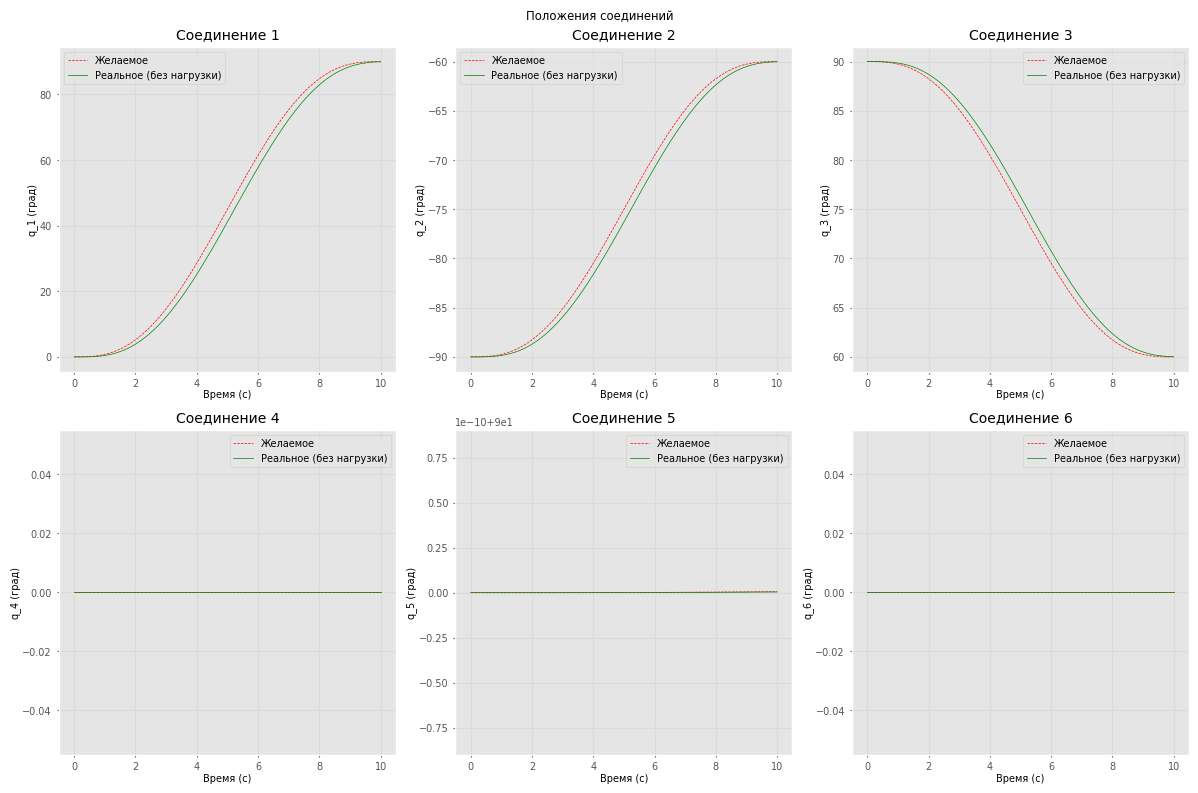

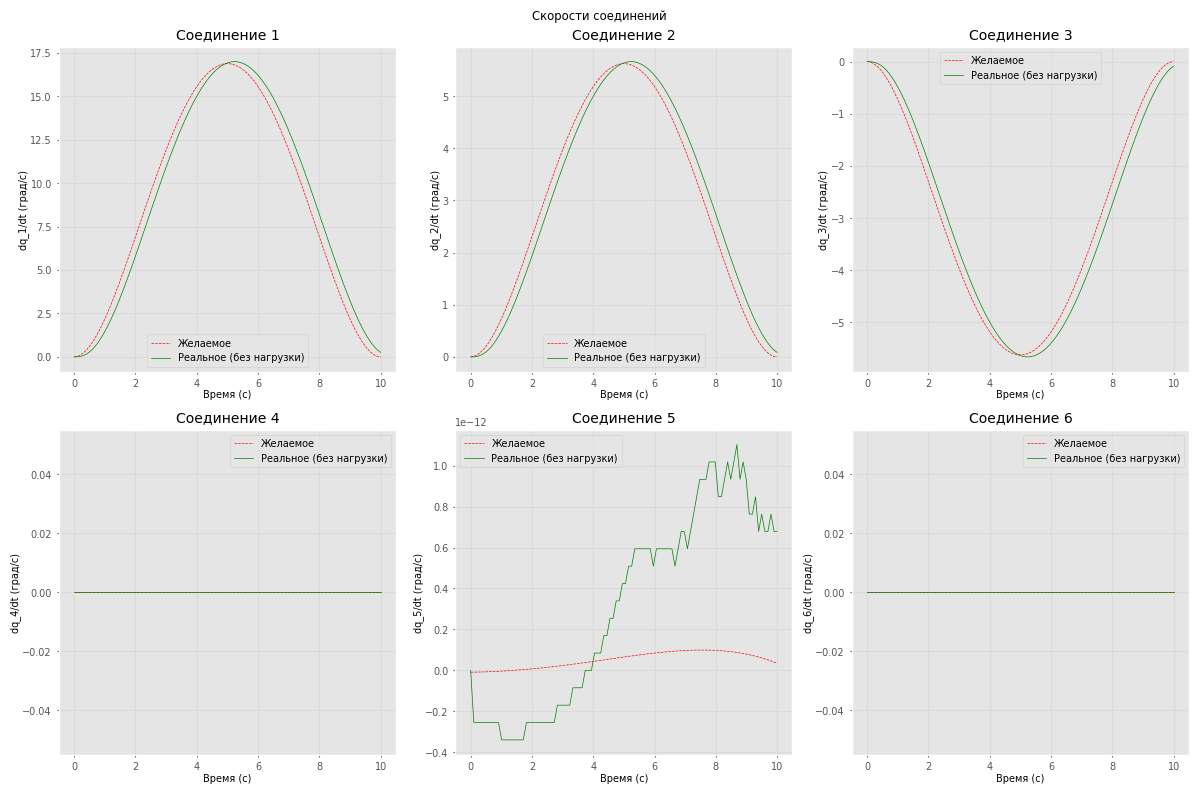

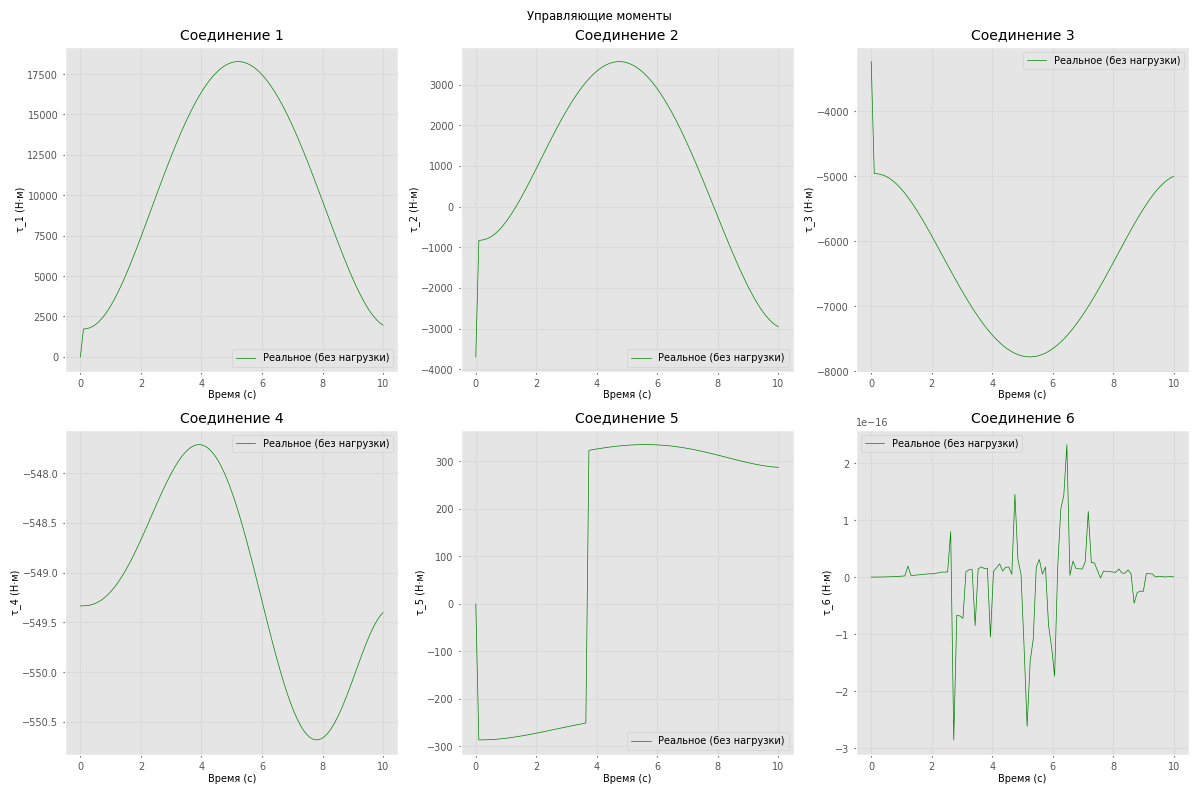

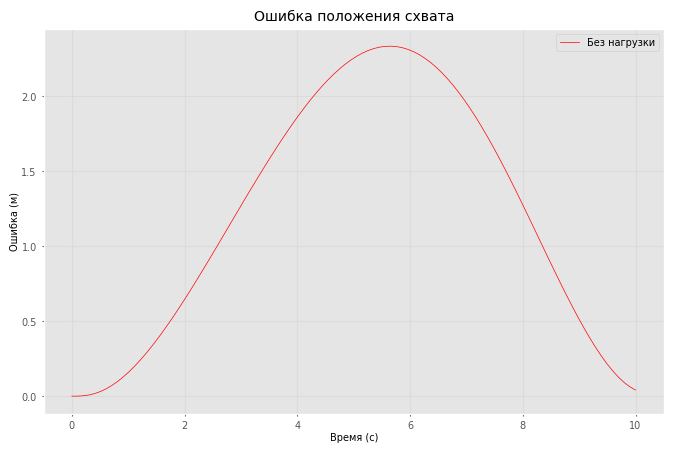

In [58]:
# Начальные условия
y0 = np.concatenate((q_start, np.zeros(6)))

# Оптимальные коэффициенты (подобраны экспериментально)
M_d_opt = np.diag([0.3, 0.3, 0.3, 0.05, 0.05, 0.05])
D_d_opt = np.diag([70, 70, 70, 15, 15, 15])
K_d_opt = np.diag([300, 300, 300, 100, 100, 100])

# Повторное моделирование с оптимальными параметрами
solution = odeint(robot_dynamics, y0, time, args=(robot, tr_1, M_d_opt, D_d_opt, K_d_opt))

# Извлечение результатов
q_traj = solution[:, :6]
qd_traj = solution[:, 6:12]

# Вычисление моментов для оптимального случая
tau_traj = []
for i in range(len(time)):
    q = q_traj[i]
    qd = qd_traj[i]
    qdd_desired = tr_1.qdd[np.argmin(np.abs(tr_1.t - time[i]))]
    q_desired = tr_1.q[np.argmin(np.abs(tr_1.t - time[i]))]
    qdd = impedance_control(q, qd, qdd_desired, M_d_opt, D_d_opt, K_d_opt, q_desired)
    tau = robot.rne(q, qd, qdd, gravity=[0, 0, -9.81])
    tau_traj.append(tau)
tau_traj = np.array(tau_traj)

# Ошибка положения схвата
error = []
for i in range(len(time)):
    T_desired = robot.fkine(tr_1.q[i])
    T_actual = robot.fkine(q_traj[i])
    error.append(np.linalg.norm(T_desired.t - T_actual.t))

plot_pos_and_v([tr_1.q, q_traj], [tr_1.qd, qd_traj], ['r--', 'g'], labels=['Желаемое', 'Реальное (без нагрузки)'])
plot_momentums([tau_traj], ['g'], ['Реальное (без нагрузки)'])
plot_error([error], ['r'], ["Без нагрузки"])

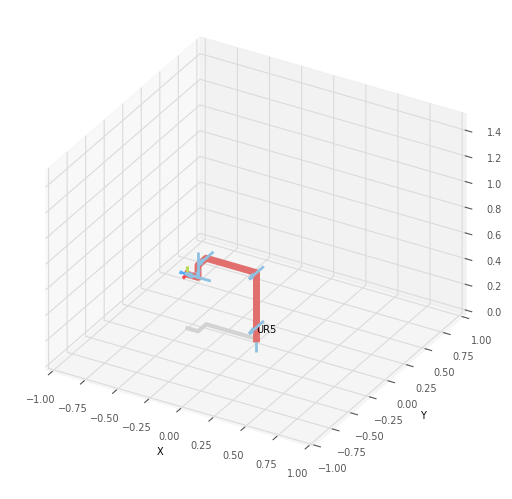

PyPlot3D backend, t = 4.99999999999999, scene:
  robot: Text(0.0, 0.0, 'UR5')

<Figure size 640x480 with 0 Axes>

In [38]:
robot.plot(q_traj, dt=0.05, backend='pyplot', 
          limits=[-1, 1, -1, 1, 0, 1.5], 
          movie='robot_control.gif')

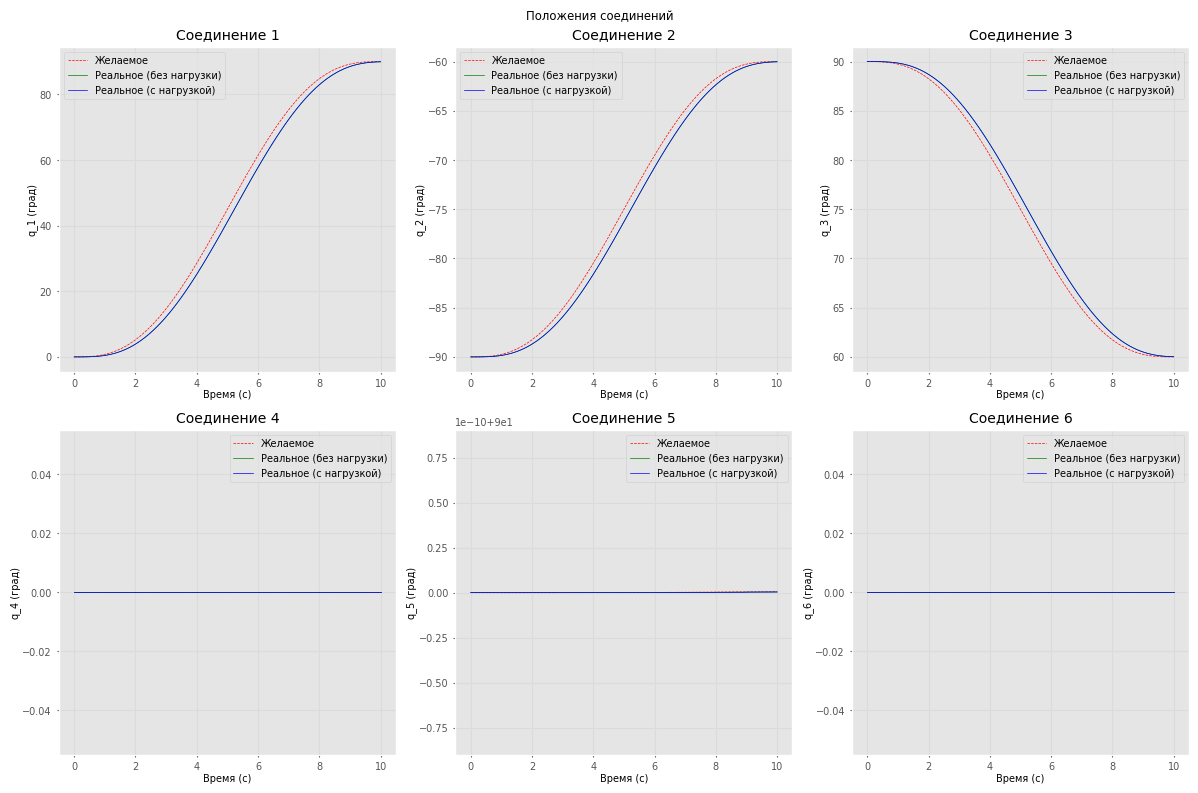

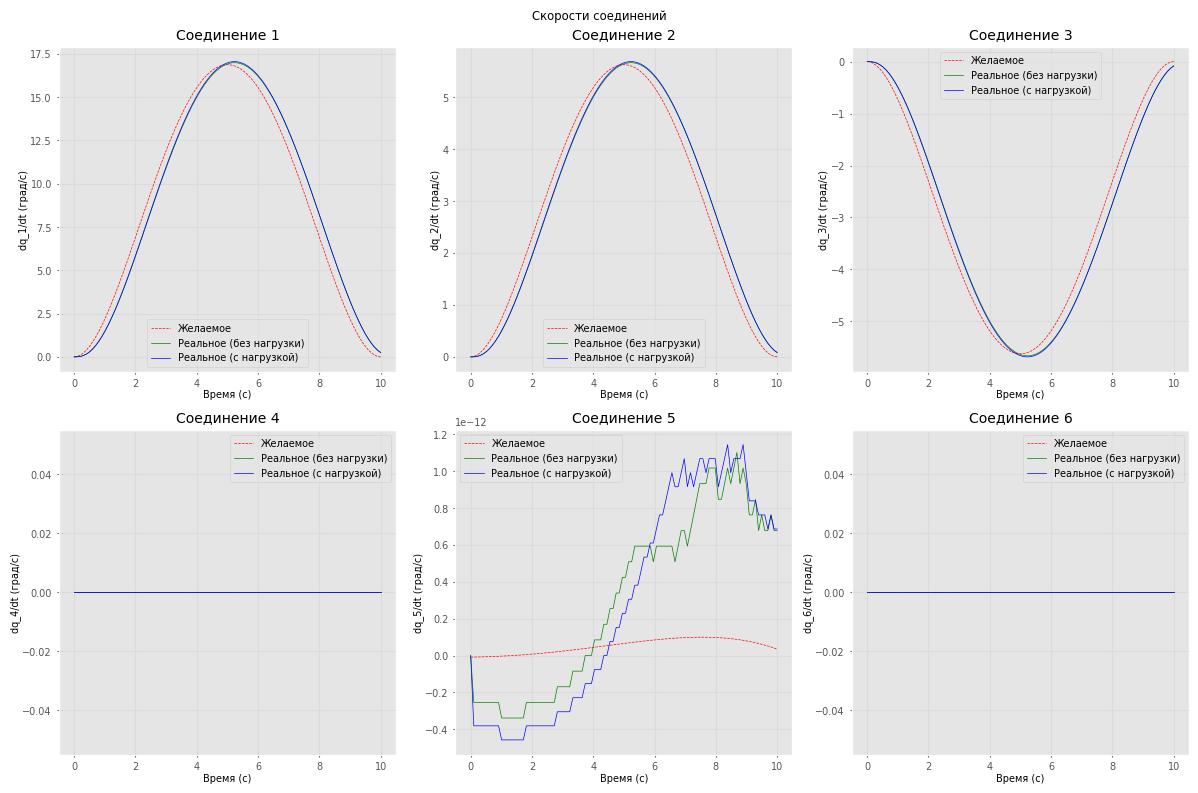

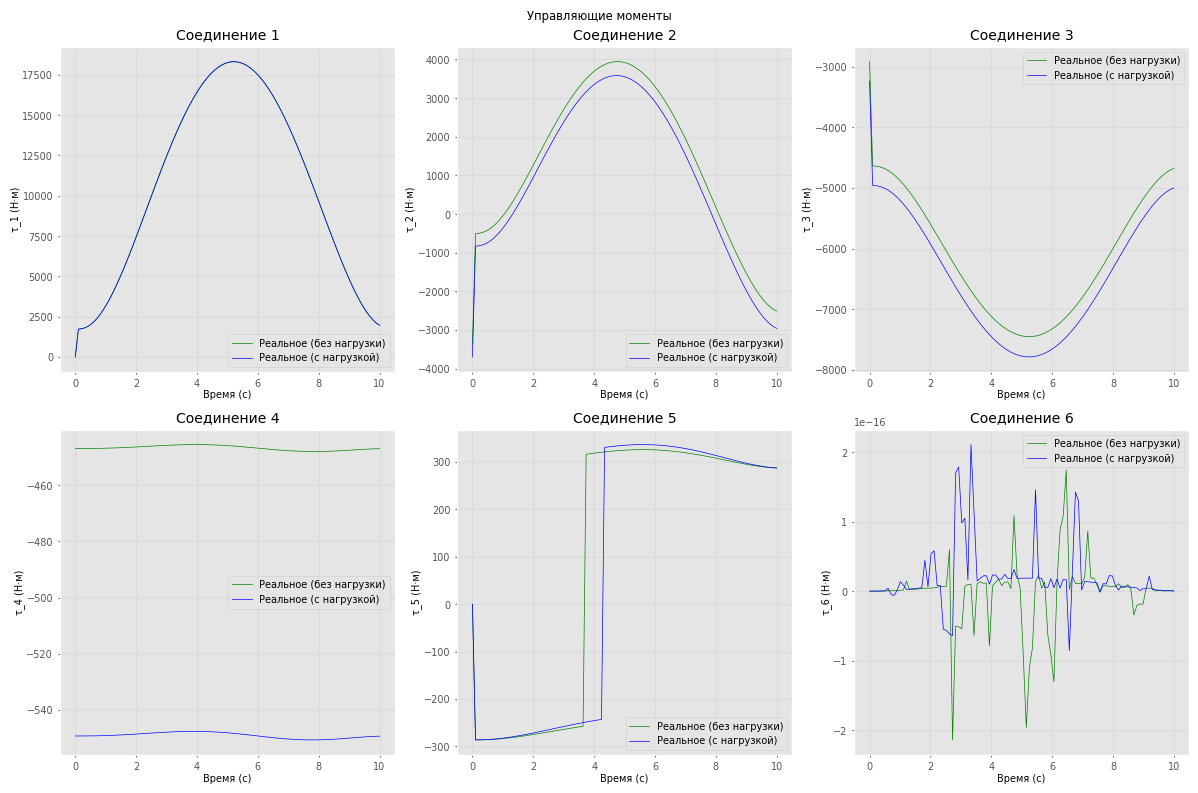

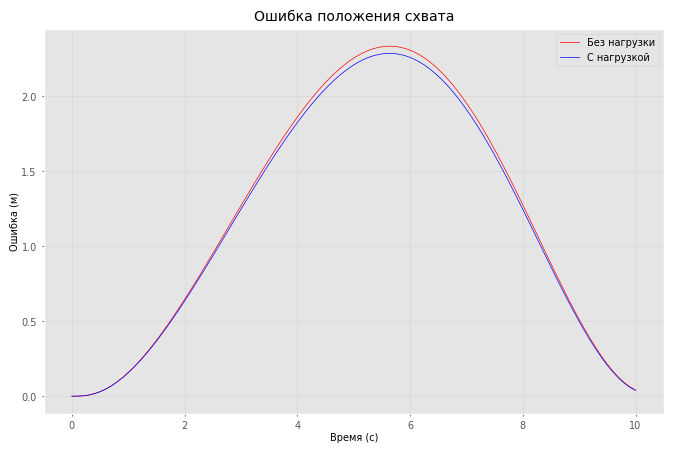

In [57]:
# Параметры полезной нагрузки
payload_mass = 1.0  # кг (пример: 1 кг нагрузки)
payload_com = [0, 0, 0.1]  # центр масс нагрузки относительно схвата
payload_inertia = [0.001, 0.001, 0.001, 0, 0, 0]  # тензор инерции нагрузки
Ixx, Iyy, Izz, Ixy, Iyz, Ixz = payload_inertia
payload_inertia_matrix = np.array([
    [Ixx, Ixy, Ixz],
    [Ixy, Iyy, Iyz],
    [Ixz, Iyz, Izz]
])


# Сохраняем оригинальные параметры последнего звена
original_mass = robot.links[5].m
original_com = robot.links[5].r
original_inertia = robot.links[5].I

# Обновляем параметры последнего звена с учетом нагрузки
robot.links[5].m = original_mass + payload_mass
robot.links[5].r = (np.array(original_com)*original_mass + np.array(payload_com)*payload_mass) / (original_mass + payload_mass)
robot.links[5].I = np.array(original_inertia) + np.array(payload_inertia_matrix)


# Функция динамики с учетом полезной нагрузки
def robot_dynamics_with_payload(y, t, robot, tr_1, M_d, D_d, K_d):
    return robot_dynamics(y, t, robot, tr_1, M_d, D_d, K_d)

# Подбор новых коэффициентов для системы с нагрузкой
M_d_payload = np.diag([0.4, 0.4, 0.4, 0.1, 0.1, 0.1])  # Увеличиваем желаемую инерцию
D_d_payload = np.diag([80, 80, 80, 20, 20, 20])       # Увеличиваем демпфирование
K_d_payload = np.diag([350, 350, 350, 120, 120, 120])  # Увеличиваем жесткость

# Моделирование с полезной нагрузкой
solution_payload = odeint(robot_dynamics_with_payload, y0, time, 
                         args=(robot, tr_1, M_d_payload, D_d_payload, K_d_payload))

# Извлечение результатов с нагрузкой
q_traj_payload = solution_payload[:, :6]
qd_traj_payload = solution_payload[:, 6:12]

# Вычисление моментов для случая с нагрузкой
tau_traj_payload = []
for i in range(len(time)):
    q = q_traj_payload[i]
    qd = qd_traj_payload[i]
    qdd_desired = tr_1.qdd[np.argmin(np.abs(tr_1.t - time[i]))]
    q_desired = tr_1.q[np.argmin(np.abs(tr_1.t - time[i]))]
    qdd = impedance_control(q, qd, qdd_desired, M_d_payload, D_d_payload, K_d_payload, q_desired)
    tau = robot.rne(q, qd, qdd, gravity=[0, 0, -9.81])
    tau_traj_payload.append(tau)
tau_traj_payload = np.array(tau_traj_payload)

# Ошибка положения схвата с нагрузкой
error_payload = []
for i in range(len(time)):
    T_desired = robot.fkine(tr_1.q[i])
    T_actual = robot.fkine(q_traj_payload[i])
    error_payload.append(np.linalg.norm(T_desired.t - T_actual.t))
    

plot_pos_and_v([tr_1.q, q_traj, q_traj_payload], [tr_1.qd, qd_traj, qd_traj_payload], ['r--', 'g', 'b'], labels=['Желаемое', 'Реальное (без нагрузки)', 'Реальное (с нагрузкой)'])
plot_momentums([tau_traj, tau_traj_payload], ['g', 'b'], ['Реальное (без нагрузки)', 'Реальное (с нагрузкой)'])
plot_error([error, error_payload], ['r', 'b'], ["Без нагрузки", 'С нагрузкой'])


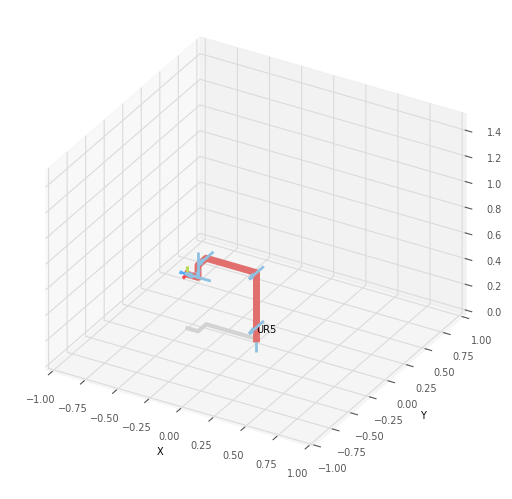

PyPlot3D backend, t = 4.99999999999999, scene:
  robot: Text(0.0, 0.0, 'UR5')

<Figure size 640x480 with 0 Axes>

In [42]:
robot.plot(q_traj_payload, dt=0.05, backend='pyplot', 
          limits=[-1, 1, -1, 1, 0, 1.5], 
          movie='robot_control_payload.gif')